In [1]:
with open('auto-mpg.names','r') as f:
    print(f.read())

1. Title: Auto-Mpg Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University. The dataset was 
                used in the 1983 American Statistical Association Exposition.
   (c) Date: July 7, 1993

3. Past Usage:
    -  See 2b (above)
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumptio

***6 пропущенных значений для horsepowe. Проще всего исключить эти 6 примеров из датасета, я так и сделаю.<br>
<br>
car name не содержит никакой важной для нас информации<br>
Все непрерывные признаки нам подходят<br>
cylinders и model year  - это упорядоченные дискретные признаки , поэтому мы можем их использовать<br>
origin - я закодирую через onehot***

In [2]:
import numpy as np
import pandas as pd

import random
import time

from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing

import matplotlib.pyplot as plt

data = []
with open('auto-mpg.data','r') as f:
    for line in f:
        tmp = line.split()[:8]
        if tmp[3]=='?':
            tmp[3] = '-1'

        tmp = [*map(float,tmp)]
        if tmp[3]==-1:
            tmp[3] = None

        data.append(tmp)

data = pd.DataFrame(data)

data.columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin']

tmp = (data.origin.to_numpy()[...,None] == data.origin.unique()[None]).astype(int)

data['origin1'] = tmp[:,0]
data['origin2'] = tmp[:,1]
data['origin3'] = tmp[:,2]

data = data.drop('origin',axis=1)

data = data.dropna()

data = data.sample(frac=1,random_state=42)
data.iloc[:,1:7] = preprocessing.scale(data.iloc[:,1:7])
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin1,origin2,origin3
79,26.0,-0.864014,-0.941647,-0.922672,-0.929585,0.892329,-1.081695,0,0,1
276,21.6,-0.864014,-0.702437,0.273935,-0.215231,0.057588,0.549168,0,0,1
248,36.1,-0.864014,-0.989490,-1.156791,-1.388139,0.311639,0.549168,0,1,0
56,26.0,-0.864014,-0.989490,-0.896659,-1.205425,1.799657,-1.353505,1,0,0
393,27.0,-0.864014,-0.520637,-0.480448,-0.221125,0.021294,1.636410,1,0,0
...,...,...,...,...,...,...,...,...,...,...
72,15.0,1.483947,1.048584,1.184397,1.077916,-1.103792,-1.081695,1,0,0
107,18.0,0.309967,0.359658,-0.116263,-0.222304,-0.196464,-0.809884,1,0,0
272,23.8,-0.864014,-0.415384,-0.506461,-0.144503,0.747157,0.549168,1,0,0
352,29.9,-0.864014,-0.922511,-1.026725,-0.704434,1.872244,1.364599,1,0,0


In [3]:
RANDOM_STATE = 0

In [4]:
train_data = data.iloc[:300]
test_data = data.iloc[300:]

X_train = train_data.iloc[:,1:].to_numpy()
y_train = train_data.iloc[:,0].to_numpy()

X_test = test_data.iloc[:,1:].to_numpy()
y_test = test_data.iloc[:,0].to_numpy()

In [5]:
class RandomTree:
    def __init__(self,X,y,depth=0,min_samples_split=2,
                 max_features=None,max_depth=np.inf,
                 min_impurity_split=1e-7,min_impurity_decrease=0.0):
        self.min_samples_split = min_samples_split
        
        if max_features is None:
            max_features = X.shape[1]
        self.max_features = max_features
        
        self.max_depth = max_depth
        self.N = X.shape[0]
        
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        
        self.ans = None
        self._Split(X,y,depth)
        
    def _Split(self,X,y,depth):        
        if depth>=self.max_depth or self._StopSplit(X,y):
            self.ans = self._Predict(y)
            return
        
        y_sum = y.sum()
        cur_score = y - y_sum/len(y)
        cur_score = cur_score[None]@cur_score[...,None]
        
        if cur_score/y.shape[0] < self.min_impurity_split:
            self.ans = self._Predict(y)
            return
        
        mins = X.min(axis=0)
        maxs = X.max(axis=0)
        
        mask = mins!=maxs
        
        features = np.arange(X.shape[1])[mask]

        if len(features)>self.max_features:
            features = random.sample(features,self.max_features)
        elif len(features)==0:
            self.ans = self._Predict(y)
            return
        
        if len(features)==X.shape[1]:
            values = X
        else:
            values = X[:,features]

        mins = mins[mask]
        maxs = maxs[mask]
        
        eps = 1e-20
        splits = np.array([random.uniform(mi+eps,ma) for mi,ma in zip(mins,maxs)])
        
        mask = values<splits

        left = y[...,None]*mask
        right = y[...,None]*~mask
        
        left_count = mask.sum(axis=0)
        right_count = (~mask).sum(axis=0)
        
        
        left_mean = left.sum(axis=0)/left_count
        right_mean = right.sum(axis=0)/right_count
        
        
        tmp =  ((y[...,None] - (mask*left_mean+(~mask)*right_mean))**2)
        scores = (tmp*mask*left_count + tmp*(~mask)*right_count).sum(axis=0)
        
        best_ind = scores.argmin()
        best_score = scores[best_ind]/mask.shape[0]
        
        
        if mask.shape[0]/self.N*(cur_score-best_score)<self.min_impurity_decrease:
            self.ans = self._Predict(y)
            return
        
        
        best_mask = mask[:,best_ind]
        
        self.split = splits[best_ind]
        self.feature = features[best_ind]    

        self.left = RandomTree(X[best_mask], y[best_mask],depth+1,
                               self.min_samples_split,self.max_features,self.max_depth)
        self.right = RandomTree(X[~best_mask],y[~best_mask],depth+1,
                               self.min_samples_split,self.max_features,self.max_depth)
        
    
    def _StopSplit(self,X,y):
        if len(X)<self.min_samples_split or (y==y[0]).all():
            return True
        else:
            return False
    
    def _Predict(self,y):
        return y.mean()
    
    def Predict(self,X):
        if self.ans:
            return np.array([self.ans]*len(X))
        
        mask = X[:,self.feature]<self.split
        y = np.empty(len(X))
        
        y[mask] = self.left.Predict(X[mask])
        y[~mask] = self.right.Predict(X[~mask])
        
        return y
    
    def height(self):
        if self.ans:
            return 1
        return max(self.left.height(),self.right.height())+1
    

In [6]:
class ExtraRandomForest:
    def __init__(self,num_tree,min_samples_split=2,max_features=None,
                 random_state = 42,max_depth=None,
                 min_impurity_split=1e-7,min_impurity_decrease=0.0):
        if max_depth is None:
            max_depth=np.inf
        self.max_depth = max_depth
            
        self.random_state = random_state
        self.max_features = max_features
        
        self.min_samples_split = min_samples_split 
        self.num_tree = num_tree
        
        self.min_impurity_split = min_impurity_split
        self.min_impurity_decrease = min_impurity_decrease
    
    def fit(self,X,y):
        random.seed(self.random_state)
        self.forest = [RandomTree(X,y,0,
                                  self.min_samples_split,self.max_features,
                                  self.max_depth,self.min_impurity_split,
                                  self.min_impurity_decrease)
                       for _ in range(self.num_tree)]
    
    def predict(self,X):
        return sum(map(lambda x:x.Predict(X),self.forest))/self.num_tree

In [7]:
tree = RandomTree(X_train,y_train)
print(tree.height())
ans = tree.Predict(X_test)
((y_test-ans)**2).sum()

13


1693.6

In [8]:
%%time

forest = ExtraRandomForest(1000,random_state=RANDOM_STATE)
forest.fit(X_train,y_train)

ans = forest.predict(X_test)
((y_test-ans)**2).sum()

Wall time: 35.8 s


577.8670159800012

In [9]:
%%time

reg = ExtraTreesRegressor(n_estimators=1000, random_state=RANDOM_STATE,n_jobs=1).fit(X_train, y_train)

ans = reg.predict(X_test)
((y_test-ans)**2).sum()

Wall time: 1.2 s


578.9002296500049

In [10]:
trees = [50,100,200,300,400,500,600,700,800,900,1000]

scores_extra = []
for tree in trees:
    forest = ExtraRandomForest(tree,random_state=RANDOM_STATE)
    forest.fit(X_train,y_train)

    ans = forest.predict(X_test)
    scores_extra.append((((y_test-ans)**2).sum(),tree))

scores_sklearn = []
for tree in trees:
    reg = ExtraTreesRegressor(n_estimators=tree, random_state=RANDOM_STATE,n_jobs=-1).fit(X_train, y_train)

    ans = reg.predict(X_test)
    scores_sklearn.append((((y_test-ans)**2).sum(),tree))

In [11]:
x = [x[1] for x in scores_sklearn]

y_sklearn = [x[0] for x in scores_sklearn]
y_extra = [x[0] for x in scores_extra]

y_bottom = [x-x*0.03 for x in y_sklearn]
y_top = [x+x*0.03 for x in y_sklearn]

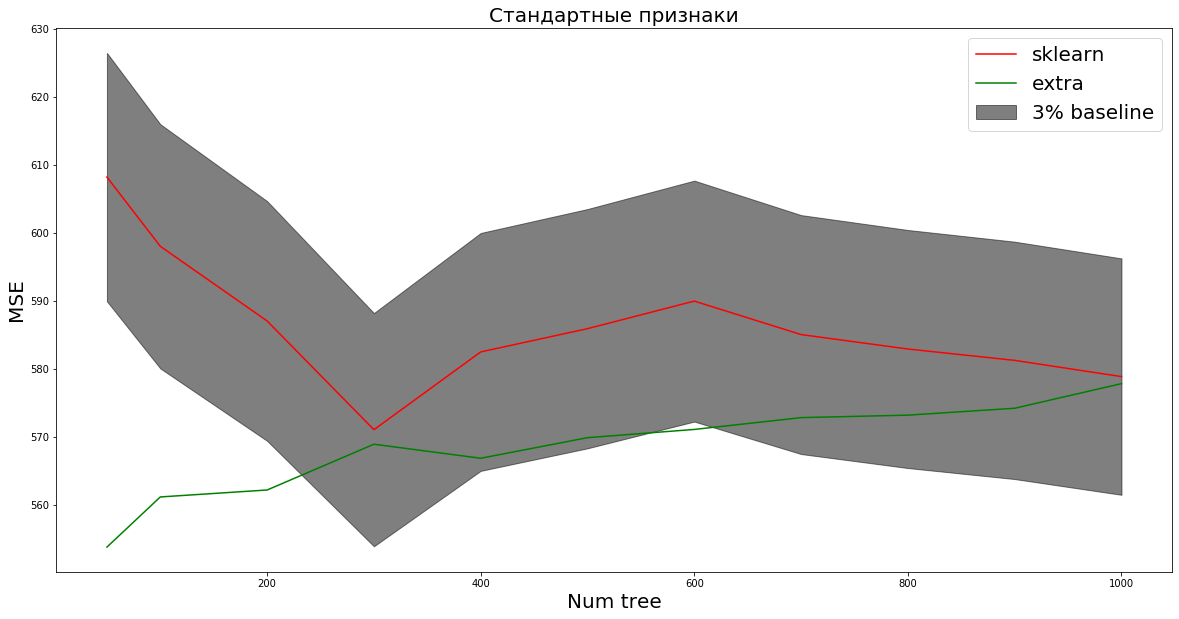

In [12]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_xlabel('Num tree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('Стандартные признаки',fontsize=20)


ax.fill_between(x, y_bottom, y_top, alpha=0.5,color='black',label='3% baseline' )
ax.plot(x,y_sklearn,'r',label='sklearn')
ax.plot(x,y_extra,'g',label='extra')
plt.legend(fontsize=20)

In [13]:
data['new_1'] = 11*data.iloc[:,1] + 5*data.iloc[:,5]

data['new_2'] = -9*data.iloc[:,2] + -1*data.iloc[:,5]
data['new_3'] = 5*data.iloc[:,2] + -2*data.iloc[:,3]

data['new_4'] = 5*data.iloc[:,4] + -3*data.iloc[:,6]

data['new_5'] = 2*data.iloc[:,5] + -3*data.iloc[:,6]


train_data = data.iloc[:300]
test_data = data.iloc[300:]

X_train = train_data.iloc[:,1:].to_numpy()
y_train = train_data.iloc[:,0].to_numpy()

X_test = test_data.iloc[:,1:].to_numpy()
y_test = test_data.iloc[:,0].to_numpy()

In [14]:
trees = [50,100,200,300,400,500,600,700,800,900,1000]

scores_extra = []
for tree in trees:
    forest = ExtraRandomForest(tree,random_state=RANDOM_STATE)
    forest.fit(X_train,y_train)

    ans = forest.predict(X_test)
    scores_extra.append((((y_test-ans)**2).sum(),tree))

scores_sklearn = []
for tree in trees:
    reg = ExtraTreesRegressor(n_estimators=tree, random_state=RANDOM_STATE,n_jobs=-1).fit(X_train, y_train)

    ans = reg.predict(X_test)
    scores_sklearn.append((((y_test-ans)**2).sum(),tree))

In [15]:
x = [x[1] for x in scores_sklearn]

y_sklearn = [x[0] for x in scores_sklearn]
y_extra = [x[0] for x in scores_extra]

y_bottom = [x-x*0.03 for x in y_sklearn]
y_top = [x+x*0.03 for x in y_sklearn]

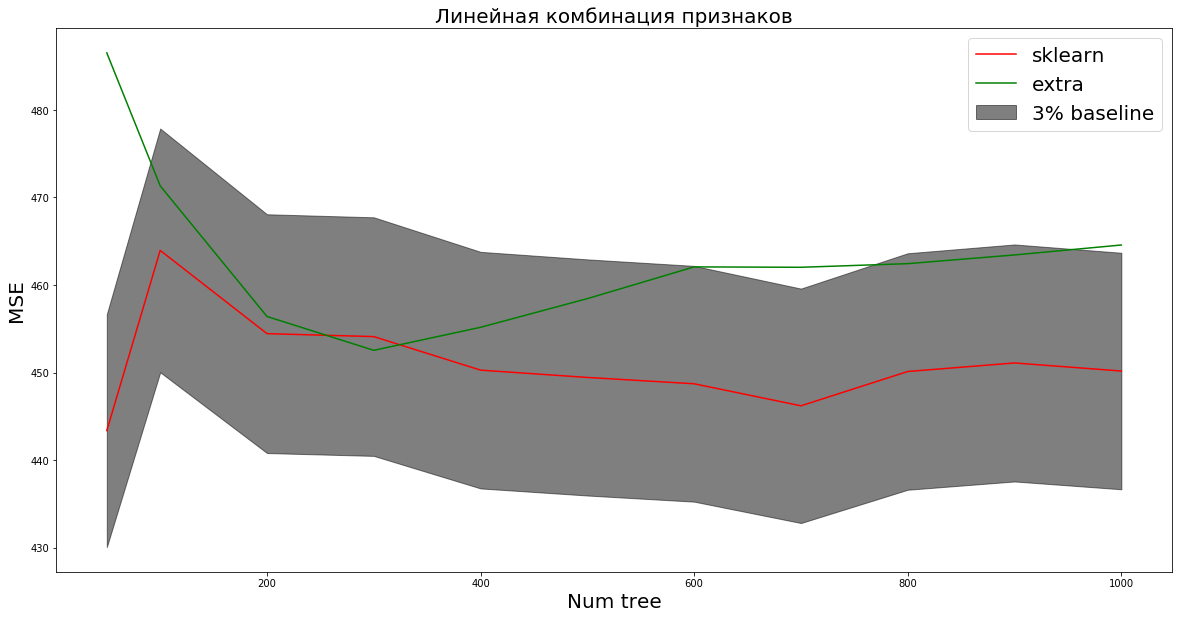

In [16]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_xlabel('Num tree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('Линейная комбинация признаков',fontsize=20)


ax.fill_between(x, y_bottom, y_top, alpha=0.5,color='black',label='3% baseline' )
ax.plot(x,y_sklearn,'r',label='sklearn')
ax.plot(x,y_extra,'g',label='extra')
plt.legend(fontsize=20)